In [82]:
# System related and data input controls
import os

# Ignore the warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# Library
import pandas as pd
import numpy as np

# Visualization
import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# 한글 설정
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. 파일 경로 설정 및 데이터 로드

In [94]:
FILE_PATH = '../dataset/실습데이터.csv'
TARGET_COLUMN = 'METAL_OIL_SUPPLY_PRESS_CONTR'

df = pd.read_csv(FILE_PATH, parse_dates=['Timestamp'])
print("✅ 데이터 로드 성공.")
print("original shape: ", df.shape)

✅ 데이터 로드 성공.
original shape:  (579297, 57)


# 2. 컬럼 이름 정리 및 인덱스 설정

In [95]:
# 컬럼 이름의 공백 제거 및 확장자 삭제
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace('.xlsx', '', regex=False)

# 불필요한 첫 번째 인덱스 컬럼 제거
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# 'Timestamp'를 DataFrame 인덱스로 설정
df = df.set_index('Timestamp')

# 공백이 많은 하단 행 제거 및 숫자형 변환
df = df.dropna(how='all')
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

### [분단위 리샘플링 버전]
# 3-1. 시계열 단위 조정 및 특징 생성

In [104]:
## 1분 단위로 리샘플링 후 직전 10분 데이터를 활용하여 시계열 예측

# 1분 단위('1T')로 리샘플링 및 평균값 집계
df_resampled = df.resample('1T').mean()
print(f"✅ 데이터 리샘플링 완료: 초단위 -> 1분 단위 ({df_resampled.shape[0]}개 관측치)")

# 결측치 처리 (선형보간을 적용)
df_resampled = df_resampled.fillna(0)

# Lag Feature 생성 (과거를 10분 데이터 특징으로 사용)
n_lags = 10
df_features = pd.DataFrame(index=df_resampled.index)
df_features[TARGET_COLUMN] = df_resampled[TARGET_COLUMN]

for i in range(1, n_lags + 1):
    df_features[f'{TARGET_COLUMN}_lag_{i}'] = df_resampled[TARGET_COLUMN].shift(i)

df_features = df_features.dropna()

✅ 데이터 리샘플링 완료: 초단위 -> 1분 단위 (17163개 관측치)


In [105]:
df_features.shape

(17153, 11)

In [106]:
# 데이터 분리 (X: 특징, y: 타겟)
X = df_features.drop(columns=[TARGET_COLUMN])
y = df_features[TARGET_COLUMN]

# 학습(Train) 및 테스트(Test) 데이터 분리 (특정 날짜 기준)
split_date = '2022-05-13 00:00:00'
X_train = X[X.index < split_date]
X_test = X[X.index >= split_date]
y_train = y[y.index < split_date]
y_test = y[y.index >= split_date]

print(f"📊 학습 데이터: {X_train.index[0]} ~ {X_train.index[-1]} ({len(X_train)}개)")
print(f"📊 테스트 데이터: {X_test.index[0]} ~ {X_test.index[-1]} ({len(X_test)}개)")

📊 학습 데이터: 2022-05-02 06:42:00 ~ 2022-05-12 23:59:00 (15438개)
📊 테스트 데이터: 2022-05-13 00:00:00 ~ 2022-05-14 04:34:00 (1715개)


# 4-1. 다중 모델 정의, 학습 및 평가

In [107]:
# 모델 딕셔너리 정의
MODELS = {
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'LightGBM Regressor': lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1),
    'XGBoost Regressor': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42, n_jobs=-1)
}

results = {}
print("\n🚀 다중 모델 학습 시작...")

for name, model in MODELS.items():
    print(f"\n--- {name} 학습 중 ---")

    # 특수 문자 포함 컬럼 이름 정리 (LightGBM/XGBoost를 위한 필수 전처리)
    X_train_clean = X_train.copy()
    X_test_clean = X_test.copy()
    X_train_clean.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_train.columns]
    X_test_clean.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_test.columns]

    # 모델 학습
    model.fit(X_train_clean, y_train)

    # 예측 수행
    y_pred = model.predict(X_test_clean)

    # 성능 평가
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # 결과 저장 (예측 결과 포함)
    results[name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'Predictions': y_pred}

    print(f"✔️ RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")


🚀 다중 모델 학습 시작...

--- Random Forest Regressor 학습 중 ---
✔️ RMSE: 46.5460, MAE: 16.0230, R2: 0.8632

--- LightGBM Regressor 학습 중 ---
✔️ RMSE: 46.8621, MAE: 17.0180, R2: 0.8614

--- XGBoost Regressor 학습 중 ---
✔️ RMSE: 46.9853, MAE: 17.6719, R2: 0.8606


# 5. 결과 종합 출력 및 시각화


🏆 최종 모델 성능 비교 (RMSE 기준 정렬)
|                         |    RMSE |     MAE |     R2 |
|:------------------------|--------:|--------:|-------:|
| Random Forest Regressor | 46.5460 | 16.0230 | 0.8632 |
| LightGBM Regressor      | 46.8621 | 17.0180 | 0.8614 |
| XGBoost Regressor       | 46.9853 | 17.6719 | 0.8606 |


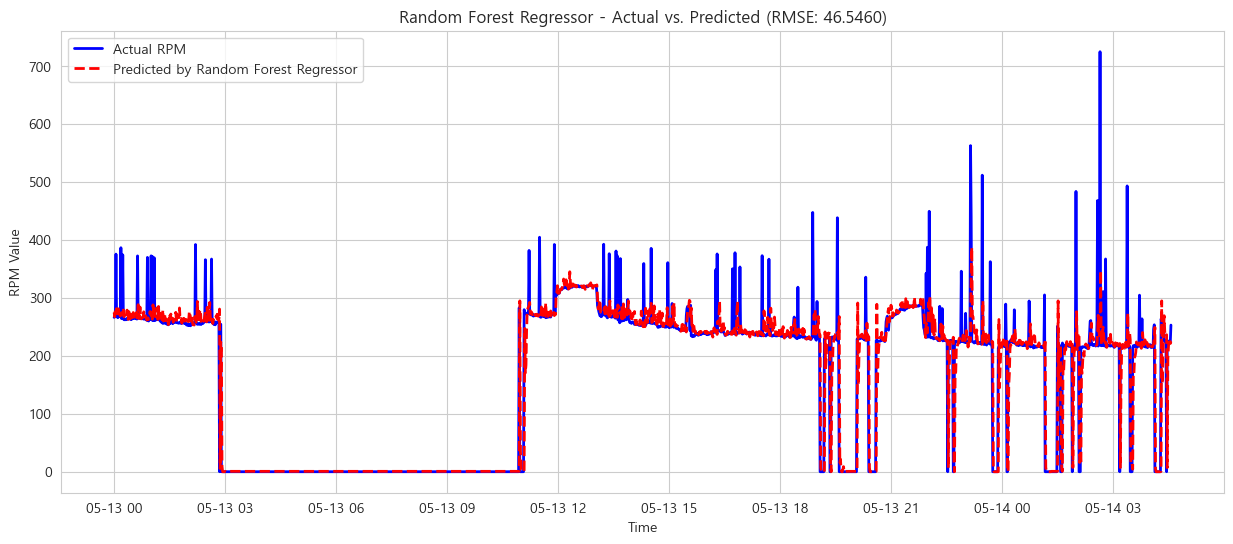

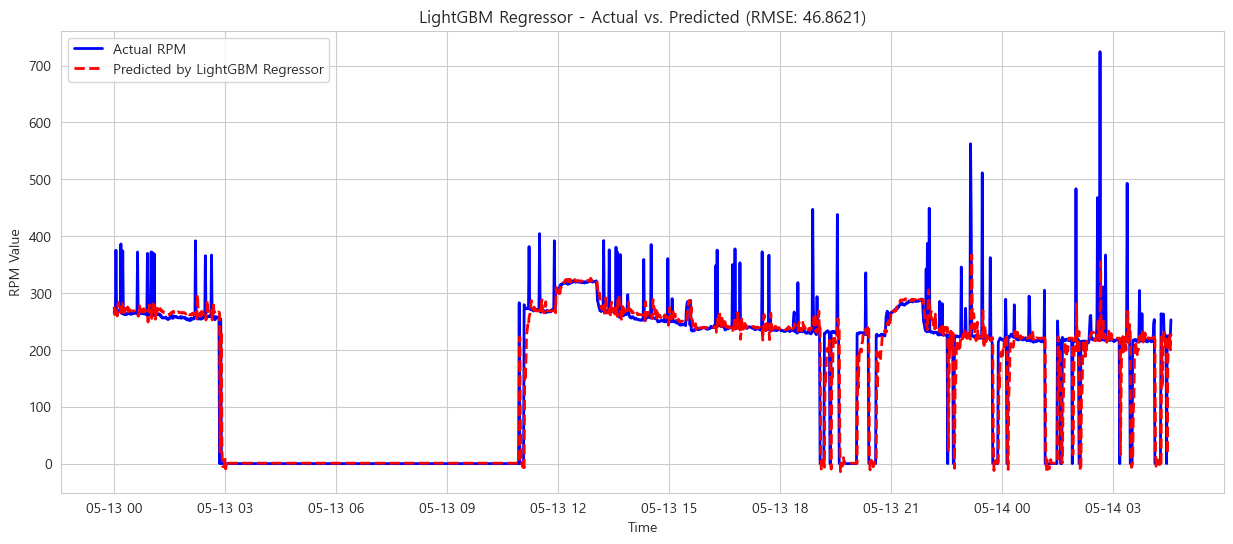

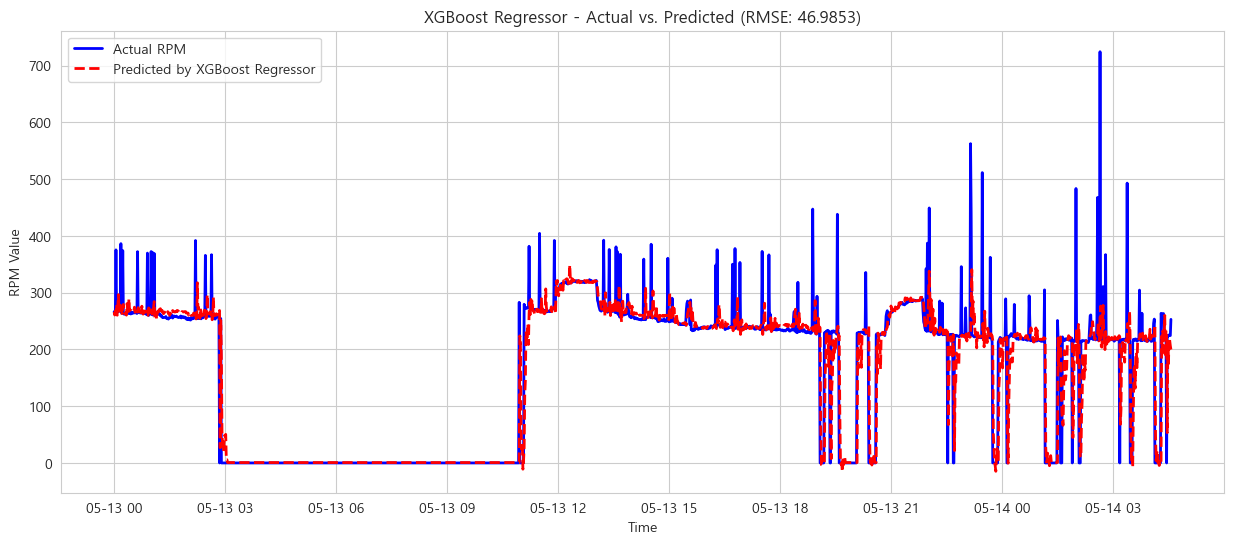


📁 모든 그래프가 '../dashboard/image' 폴더에 저장되었습니다.

✨ 가장 성능이 좋은 모델(Random Forest Regressor)로 예측한 다음 1분의 METAL_OIL_SUPPLY_PRESS_CONTR 예측값: 224.6594


In [109]:
# 결과 DataFrame 생성 및 정렬
results_df = pd.DataFrame({
    name: {k: v for k, v in data.items() if k != 'Predictions'}
    for name, data in results.items()
}).T
results_df = results_df.sort_values(by='RMSE', ascending=True)

print("\n==================================================================")
print("🏆 최종 모델 성능 비교 (RMSE 기준 정렬)")
print("==================================================================")
print(results_df.to_markdown(floatfmt=".4f"))
print("==================================================================")

# 그래프 저장 폴더 생성
import os
output_dir = '../dashboard/image'
os.makedirs(output_dir, exist_ok=True)

# 💡 모든 모델의 예측 결과를 개별적으로 시각화합니다.
for model_name, data in results.items():
    predictions = data['Predictions']
    rmse_value = results_df.loc[model_name, 'RMSE'] # RMSE 값을 결과표에서 가져옴

    plt.figure(figsize=(15, 6))
    plt.plot(y_test.index, y_test.values, label='Actual RPM', color='blue', linewidth=2)
    plt.plot(y_test.index, predictions, label=f'Predicted by {model_name}', color='red', linestyle='--', linewidth=2)

    plt.title(f'{model_name} - Actual vs. Predicted (RMSE: {rmse_value:.4f})')
    plt.xlabel('Time')
    plt.ylabel('RPM Value')
    plt.legend()
    plt.grid(True)

    # 그래프 저장
    safe_model_name = "".join(c if c.isalnum() else "_" for c in model_name)
    plt.savefig(f'{output_dir}/M_{safe_model_name}_actual_pred.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

print(f"\n📁 모든 그래프가 '{output_dir}' 폴더에 저장되었습니다.")

# (선택 사항) 다음 시점 예측 (가장 좋은 모델 사용)
best_model_name = results_df.index[0]
best_model = MODELS[best_model_name]

# 예측에 사용할 데이터 (컬럼 이름 정리 필요)
last_data = X.iloc[-1].to_frame().T
last_data.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in last_data.columns]
next_prediction = best_model.predict(last_data)
print(f"\n✨ 가장 성능이 좋은 모델({best_model_name})로 예측한 다음 1분의 {TARGET_COLUMN} 예측값: {next_prediction[0]:.4f}")


🏆 최종 모델 성능 비교 (RMSE 기준 정렬)
|                         |    RMSE |     MAE |     R2 |
|:------------------------|--------:|--------:|-------:|
| Random Forest Regressor | 46.5460 | 16.0230 | 0.8632 |
| LightGBM Regressor      | 46.8621 | 17.0180 | 0.8614 |
| XGBoost Regressor       | 46.9853 | 17.6719 | 0.8606 |


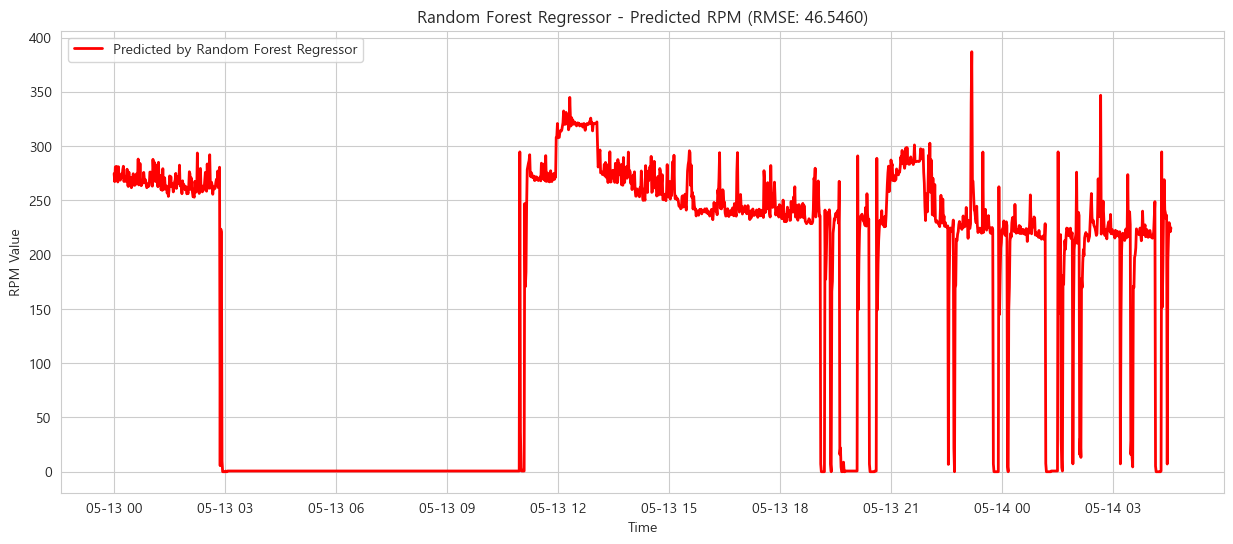

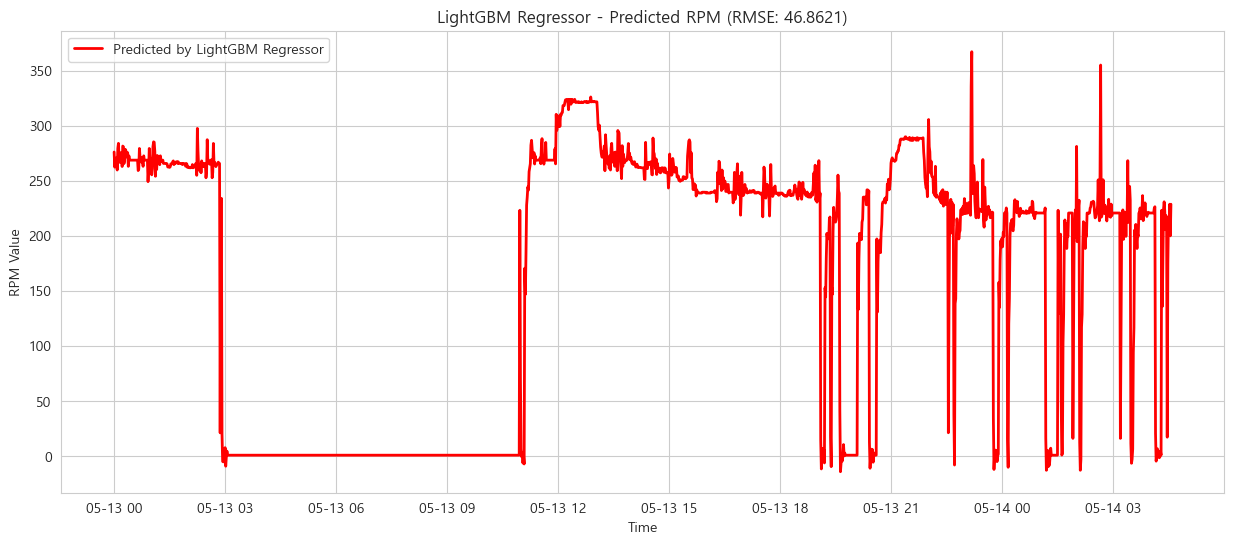

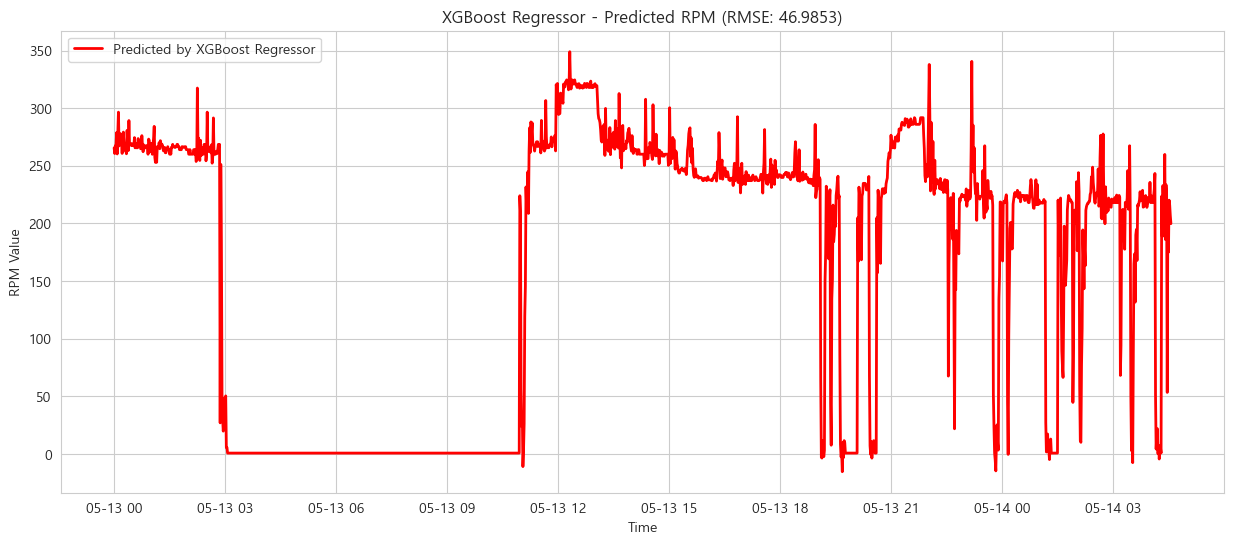


📁 모든 그래프가 '../dashboard/image' 폴더에 저장되었습니다.

✨ 가장 성능이 좋은 모델(Random Forest Regressor)로 예측한 다음 1분의 METAL_OIL_SUPPLY_PRESS_CONTR 예측값: 224.6594


In [110]:
# 결과 DataFrame 생성 및 정렬
results_df = pd.DataFrame({
    name: {k: v for k, v in data.items() if k != 'Predictions'}
    for name, data in results.items()
}).T
results_df = results_df.sort_values(by='RMSE', ascending=True)

print("\n==================================================================")
print("🏆 최종 모델 성능 비교 (RMSE 기준 정렬)")
print("==================================================================")
print(results_df.to_markdown(floatfmt=".4f"))
print("==================================================================")

# 그래프 저장 폴더 생성
import os
output_dir = '../dashboard/image'
os.makedirs(output_dir, exist_ok=True)

# 💡 모든 모델의 예측 결과를 개별적으로 시각화합니다.
for model_name, data in results.items():
    predictions = data['Predictions']
    rmse_value = results_df.loc[model_name, 'RMSE'] # RMSE 값을 결과표에서 가져옴

    plt.figure(figsize=(15, 6))
    plt.plot(y_test.index, predictions, label=f'Predicted by {model_name}', color='red', linewidth=2)

    plt.title(f'{model_name} - Predicted RPM (RMSE: {rmse_value:.4f})')
    plt.xlabel('Time')
    plt.ylabel('RPM Value')
    plt.legend()
    plt.grid(True)

    # 그래프 저장
    safe_model_name = "".join(c if c.isalnum() else "_" for c in model_name)
    plt.savefig(f'{output_dir}/M_{safe_model_name}_pred.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

print(f"\n📁 모든 그래프가 '{output_dir}' 폴더에 저장되었습니다.")

# (선택 사항) 다음 시점 예측 (가장 좋은 모델 사용)
best_model_name = results_df.index[0]
best_model = MODELS[best_model_name]

# 예측에 사용할 데이터 (컬럼 이름 정리 필요)
last_data = X.iloc[-1].to_frame().T
last_data.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in last_data.columns]
next_prediction = best_model.predict(last_data)
print(f"\n✨ 가장 성능이 좋은 모델({best_model_name})로 예측한 다음 1분의 {TARGET_COLUMN} 예측값: {next_prediction[0]:.4f}")

---

### [초단위 예측 버전]
# 3-2. 시계열 단위 조정 및 특징 생성


In [111]:
## 원본 데이터(3초 단위의 데이터)를 이용해 직전 60개(60초) 데이터를 활용하여 시계열 예측

df_original = df.copy() # 원본 DataFrame을 그대로 사용

# 결측치 처리 (선형보간 적용)
# 3초 단위 데이터에 바로 적용
df_original = df_original.fillna(0)

# Lag Feature 생성 (과거 30개 시점(=30초)의 데이터를 특징으로 사용)
n_lags = 30
df_features = pd.DataFrame(index=df_original.index)
df_features[TARGET_COLUMN] = df_original[TARGET_COLUMN]

for i in range(1, n_lags + 1):
    # 과거 20개 시점, 즉 30초 이전의 데이터를 특징으로 사용합니다.
    df_features[f'{TARGET_COLUMN}_lag_{i}'] = df_original[TARGET_COLUMN].shift(i)

df_features = df_features.dropna()

# 데이터 분리 (X: 특징, y: 타겟)
X = df_features.drop(columns=[TARGET_COLUMN])
y = df_features[TARGET_COLUMN]

# 학습(Train) 및 테스트(Test) 데이터 분리 (특정 날짜 기준)
split_date = '2022-05-13 00:00:00'
X_train = X[X.index < split_date]
X_test = X[X.index >= split_date]
y_train = y[y.index < split_date]
y_test = y[y.index >= split_date]

print(f"📊 학습 데이터: {X_train.index[0]} ~ {X_train.index[-1]} ({len(X_train)}개)")
print(f"📊 테스트 데이터: {X_test.index[0]} ~ {X_test.index[-1]} ({len(X_test)}개)")

📊 학습 데이터: 2022-05-02 06:33:03 ~ 2022-05-12 23:59:59 (525460개)
📊 테스트 데이터: 2022-05-13 00:00:00 ~ 2022-05-14 04:34:46 (53807개)


# 4-2. 다중 모델 정의, 학습 및 평가

In [112]:
# 모델 딕셔너리 정의
MODELS = {
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'LightGBM Regressor': lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1),
    'XGBoost Regressor': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42, n_jobs=-1)
}

results = {}
print("\n🚀 다중 모델 학습 시작...")

for name, model in MODELS.items():
    print(f"\n--- {name} 학습 중 ---")

    # 특수 문자 포함 컬럼 이름 정리 (LightGBM/XGBoost를 위한 필수 전처리)
    X_train_clean = X_train.copy()
    X_test_clean = X_test.copy()
    X_train_clean.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_train.columns]
    X_test_clean.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_test.columns]

    # 모델 학습
    model.fit(X_train_clean, y_train)

    # 예측 수행
    y_pred = model.predict(X_test_clean)

    # 성능 평가
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # 결과 저장 (예측 결과 포함)
    results[name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'Predictions': y_pred}

    print(f"✔️ RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")


🚀 다중 모델 학습 시작...

--- Random Forest Regressor 학습 중 ---
✔️ RMSE: 227.0004, MAE: 25.3569, R2: -0.0745

--- LightGBM Regressor 학습 중 ---
✔️ RMSE: 217.6201, MAE: 14.9037, R2: 0.0125

--- XGBoost Regressor 학습 중 ---
✔️ RMSE: 223.0954, MAE: 17.8277, R2: -0.0378


# 5. 결과 종합 출력 및 시각화


🏆 최종 모델 성능 비교 (RMSE 기준 정렬)
|                         |     RMSE |     MAE |      R2 |
|:------------------------|---------:|--------:|--------:|
| LightGBM Regressor      | 217.6201 | 14.9037 |  0.0125 |
| XGBoost Regressor       | 223.0954 | 17.8277 | -0.0378 |
| Random Forest Regressor | 227.0004 | 25.3569 | -0.0745 |


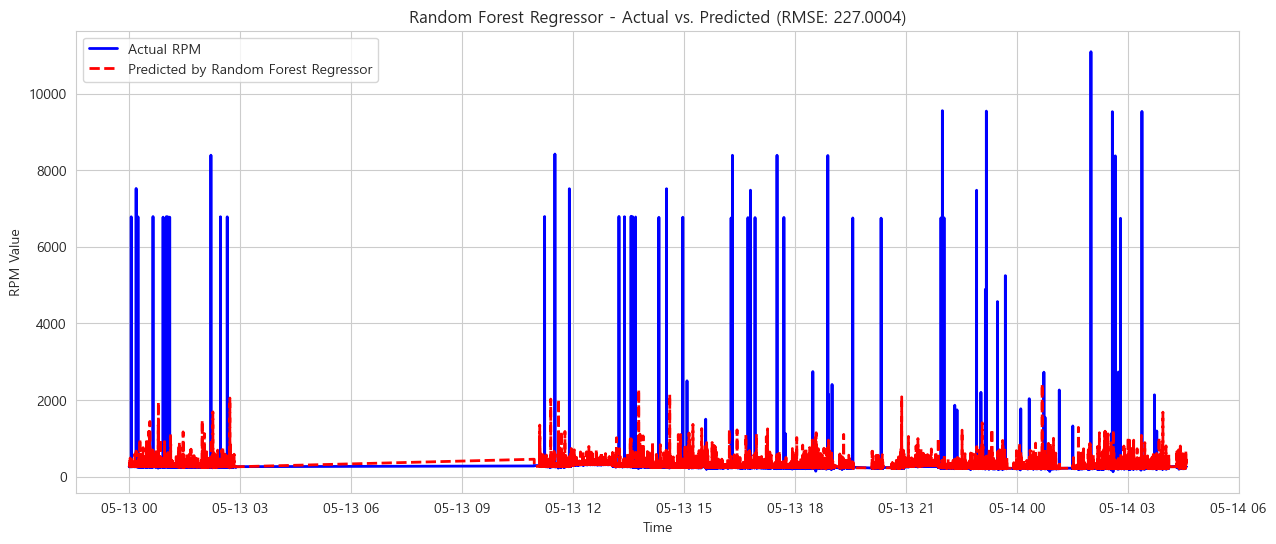

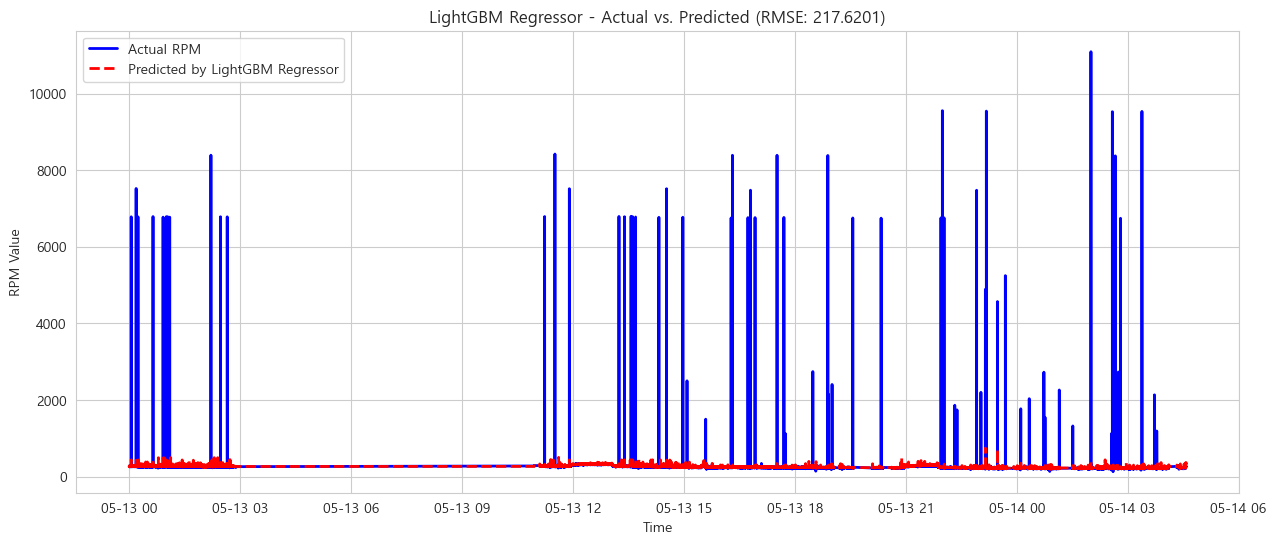

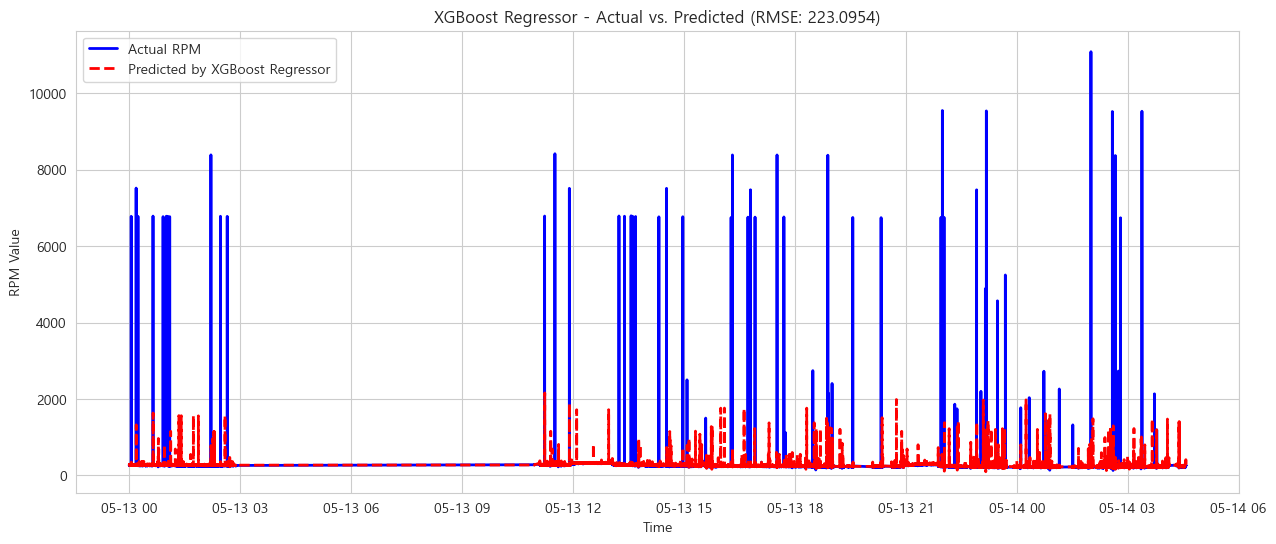


📁 모든 그래프가 '../dashboard/image' 폴더에 저장되었습니다.

✨ 가장 성능이 좋은 모델(LightGBM Regressor)로 예측한 다음 1분의 METAL_OIL_SUPPLY_PRESS_CONTR 예측값: 367.0663


In [114]:
# 결과 DataFrame 생성 및 정렬
results_df = pd.DataFrame({
    name: {k: v for k, v in data.items() if k != 'Predictions'}
    for name, data in results.items()
}).T
results_df = results_df.sort_values(by='RMSE', ascending=True)

print("\n==================================================================")
print("🏆 최종 모델 성능 비교 (RMSE 기준 정렬)")
print("==================================================================")
print(results_df.to_markdown(floatfmt=".4f"))
print("==================================================================")

# 그래프 저장 폴더 생성
import os
output_dir = '../dashboard/image'
os.makedirs(output_dir, exist_ok=True)

# 💡 모든 모델의 예측 결과를 개별적으로 시각화합니다.
for model_name, data in results.items():
    predictions = data['Predictions']
    rmse_value = results_df.loc[model_name, 'RMSE'] # RMSE 값을 결과표에서 가져옴

    plt.figure(figsize=(15, 6))
    plt.plot(y_test.index, y_test.values, label='Actual RPM', color='blue', linewidth=2)
    plt.plot(y_test.index, predictions, label=f'Predicted by {model_name}', color='red', linestyle='--', linewidth=2)

    plt.title(f'{model_name} - Actual vs. Predicted (RMSE: {rmse_value:.4f})')
    plt.xlabel('Time')
    plt.ylabel('RPM Value')
    plt.legend()
    plt.grid(True)

    # 그래프 저장
    safe_model_name = "".join(c if c.isalnum() else "_" for c in model_name)
    plt.savefig(f'{output_dir}/S_{safe_model_name}_actual_pred.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

print(f"\n📁 모든 그래프가 '{output_dir}' 폴더에 저장되었습니다.")

# (선택 사항) 다음 시점 예측 (가장 좋은 모델 사용)
best_model_name = results_df.index[0]
best_model = MODELS[best_model_name]

# 예측에 사용할 데이터 (컬럼 이름 정리 필요)
last_data = X.iloc[-1].to_frame().T
last_data.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in last_data.columns]
next_prediction = best_model.predict(last_data)
print(f"\n✨ 가장 성능이 좋은 모델({best_model_name})로 예측한 다음 1분의 {TARGET_COLUMN} 예측값: {next_prediction[0]:.4f}")